In [77]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm
import seaborn as sns

# Data Processing

In [2]:
df = pd.read_csv("./outputs/pos_filtered_df.csv")
df.shape

(6114, 68)

Text(0, 0.5, 'Counts')

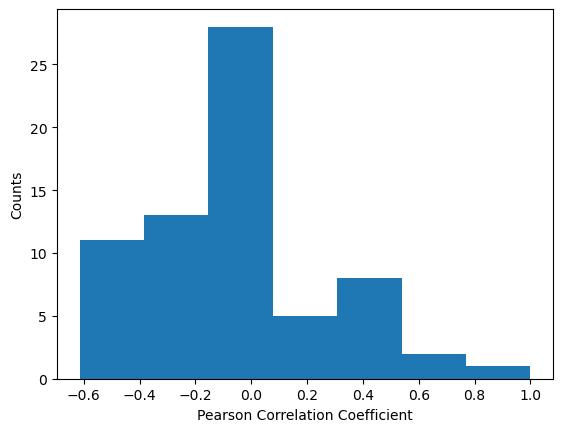

In [3]:
pear_corrs = df.corrwith(df["V202073"])
plt.hist(pear_corrs, bins=7)
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Counts")

In [140]:
bound = 0.4
condition = (pear_corrs > bound) | (pear_corrs < -bound)
vals = pear_corrs[condition].sort_values()
print(vals)
locations = vals.index
locations = locations.drop("V202073")

V201308x   -0.615081
V201377    -0.587636
V201324    -0.510070
V201376    -0.484283
V201420x   -0.458394
V201375x   -0.430894
V201120    -0.430512
V201123    -0.426953
V201335    -0.418007
V201336    -0.406544
V201305x    0.423873
V201115     0.435376
V201320x    0.472086
V201119     0.478036
V201121     0.483832
V201314x    0.509381
V201346     0.615425
V201356x    0.616546
V202073     1.000000
dtype: float64


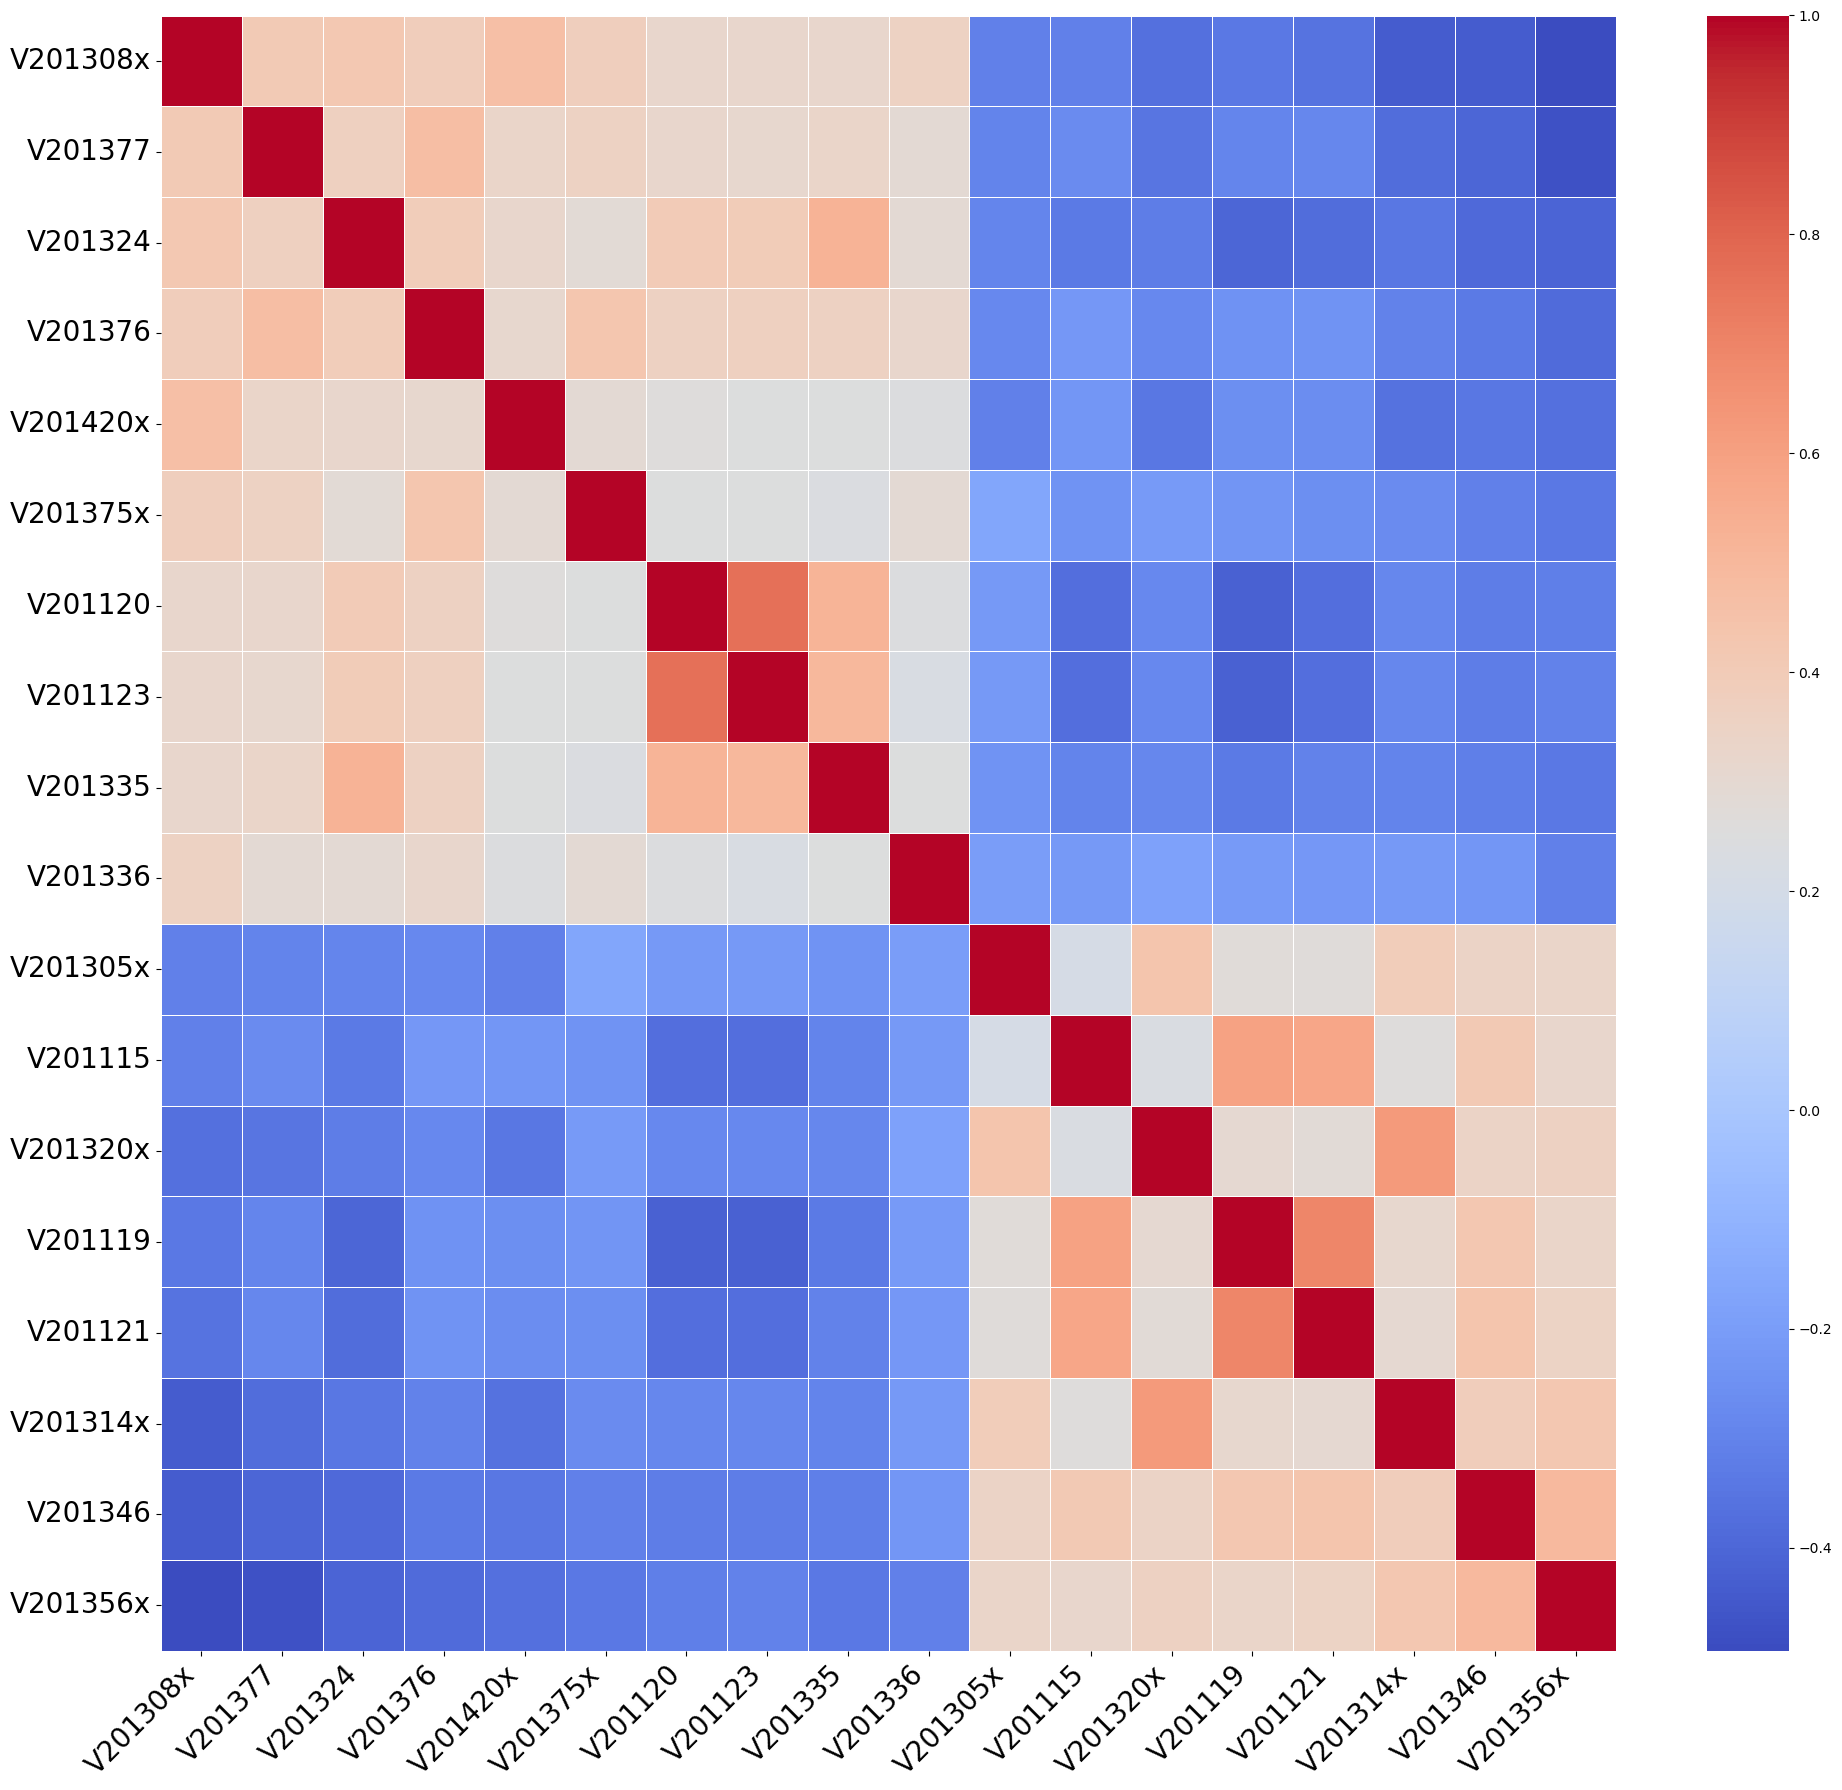

In [141]:
correlation_matrix = df[locations].corr()

plt.figure(figsize=(20, 18))
sns.heatmap(
    correlation_matrix,
    # annot=True,          # Show the correlation values on the map
    cmap='coolwarm',     # Colormap (red for positive, blue for negative)
    # fmt=".2f",           # Format the annotations to 2 decimal places
    linewidths=.5,       # Space between cells
    cbar=True            # Show the color bar
)
# plt.title('Correlation Matrix of DataFrame Features', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(rotation=0, fontsize=20)
plt.tight_layout()
plt.savefig("./outputs/corr_matrix.png")
plt.show()

In [142]:
locations = list(locations)
limit_corr = 0.6
for i, key in enumerate(correlation_matrix):
    for key2, val in enumerate(correlation_matrix[key][:i]):
        key2 = correlation_matrix.columns[key2]
        if key == key2:
            continue

        rem_k = key if abs(vals[key]) < abs(vals[key2]) else key2
        if abs(val) > limit_corr and rem_k in locations:
            print(key, key2, rem_k)
            locations.remove(rem_k)
len(locations), locations 

V201123 V201120 V201123
V201121 V201119 V201119
V201314x V201320x V201320x


(15,
 ['V201308x',
  'V201377',
  'V201324',
  'V201376',
  'V201420x',
  'V201375x',
  'V201120',
  'V201335',
  'V201336',
  'V201305x',
  'V201115',
  'V201121',
  'V201314x',
  'V201346',
  'V201356x'])

In [7]:
y_data = df["V202073"].astype(int).to_numpy()
train_df = df.drop(["V202073"], axis=1)
Y = np.where(y_data == 2, 0, y_data)

X = train_df[locations].to_numpy()

X_test, X_train, Y_test, Y_train = train_test_split(X, Y, train_size=0.3)
X_train.shape, Y_test.shape

((4280, 15), (1834,))

(array([ 765.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1069.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

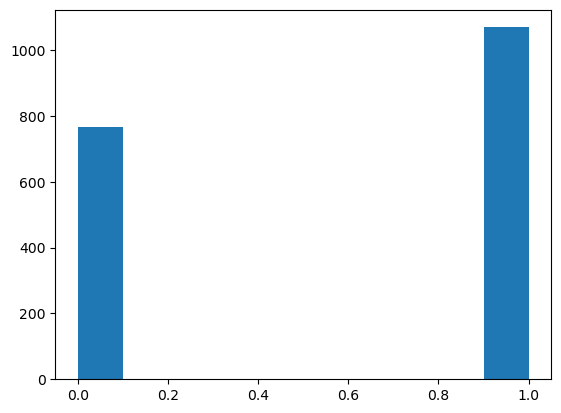

In [8]:
plt.hist(Y_test)

# Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [64]:
clf = LogisticRegression()
clf.fit(X_train, Y_train)

LogisticRegression()

In [59]:
y_pred = clf.predict(X_test)

y_pred = np.where(y_pred < 0.5, 0, 1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       765
           1       0.94      0.93      0.93      1069

    accuracy                           0.92      1834
   macro avg       0.92      0.92      0.92      1834
weighted avg       0.92      0.92      0.92      1834



In [223]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [224]:
y_pred = clf.predict(X_test)

y_pred = np.where(y_pred < 0.5, 0, 1)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       765
           1       0.94      0.93      0.93      1069

    accuracy                           0.92      1834
   macro avg       0.92      0.92      0.92      1834
weighted avg       0.92      0.92      0.92      1834



In [225]:
logistic = LogisticRegression(solver='liblinear', max_iter=1000) # Use a solver compatible with L1/L2

# 2. Define the Parameter Grid
# The keys must match the parameter names of the estimator
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],            # Inverse of regularization strength
    'penalty': ['l1', 'l2']                          # Specify the norm used in the penalization
}

# 3. Create the GridSearchCV Object
grid_search = GridSearchCV(
    estimator=logistic,        # The model to tune
    param_grid=param_grid,     # The grid of hyperparameters
    scoring='f1',        # Metric for evaluation (e.g., 'accuracy', 'f1', 'roc_auc')
    cv=5,                      # Number of cross-validation folds
    verbose=2,                 # Controls the verbosity of the output (0=silent, 1=some messages, 2=full details)
    n_jobs=-1                  # Use all available CPU cores for parallel processing
)

# 4. Fit the Data (Run the exhaustive search)
print("Starting Grid Search...")
grid_search.fit(X_train, Y_train)
print("Grid Search complete.")

y_pred = grid_search.predict(X_test)
print(classification_report(Y_test, y_pred))

Starting Grid Search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid Search complete.
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       765
           1       0.93      0.94      0.94      1069

    accuracy                           0.93      1834
   macro avg       0.92      0.92      0.92      1834
weighted avg       0.93      0.93      0.93      1834



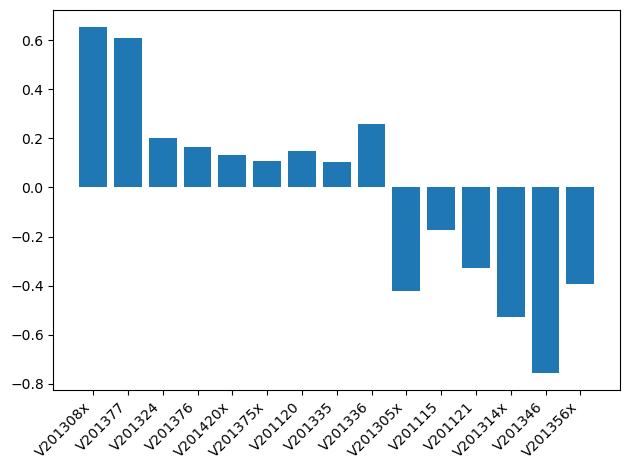

In [226]:
coef = grid_search.best_estimator_.coef_[0]
plt.bar(range(len(coef)), coef)
plt.xticks(range(len(coef)), [locations[i] for i in range(len(coef))], rotation=45, ha='right', fontsize=10)
# plt.xticks(rotation=45, ha='right', fontsize=20)
plt.tight_layout()
plt.savefig("./outputs/logistic_coef.png")
plt.show()

# Decision Tree

In [227]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz

In [228]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5)

In [229]:
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       765
           1       0.90      0.93      0.91      1069

    accuracy                           0.90      1834
   macro avg       0.90      0.89      0.90      1834
weighted avg       0.90      0.90      0.90      1834



In [230]:
df.columns[38]

'V201346'

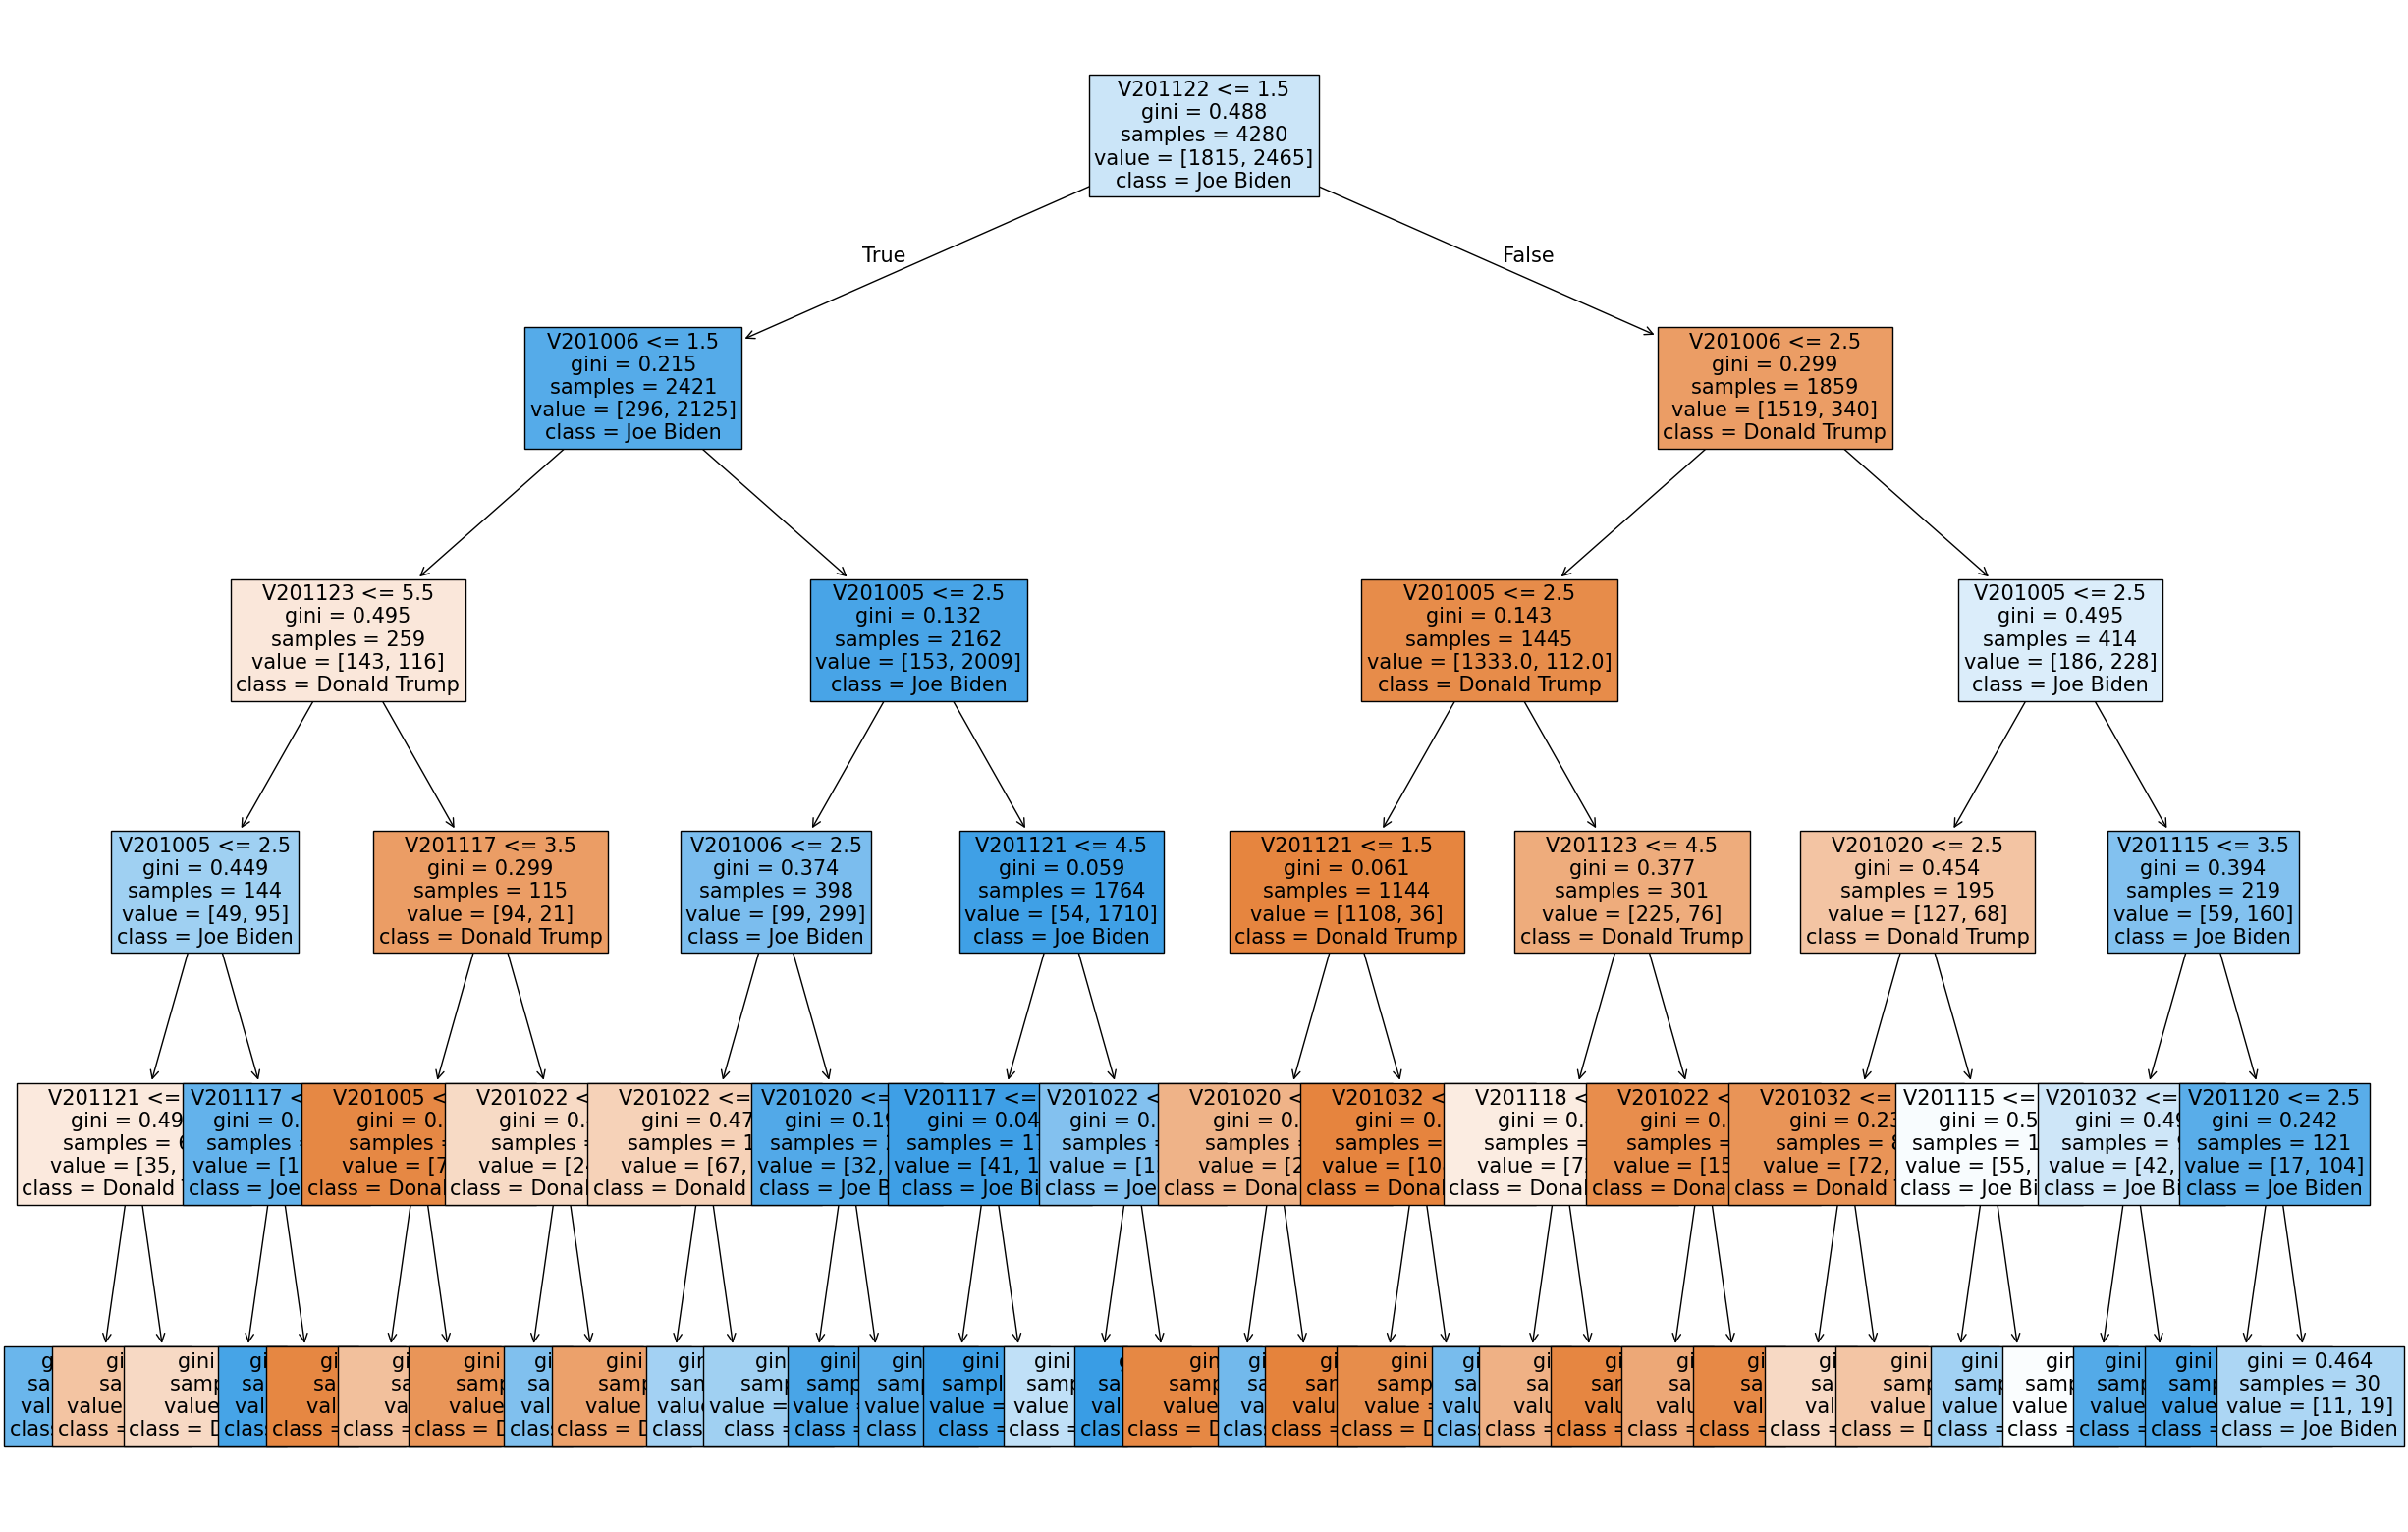

In [231]:
plt.figure(figsize=(30, 20))
_ = plot_tree(clf, filled=True, class_names=["Donald Trump", "Joe Biden"], feature_names=df.columns, fontsize=15)
plt.savefig('./outputs/decision_tree_big.png', bbox_inches="tight")
# plt.savefig('./outputs/decision_tree_big.svg', bbox_inches="tight")

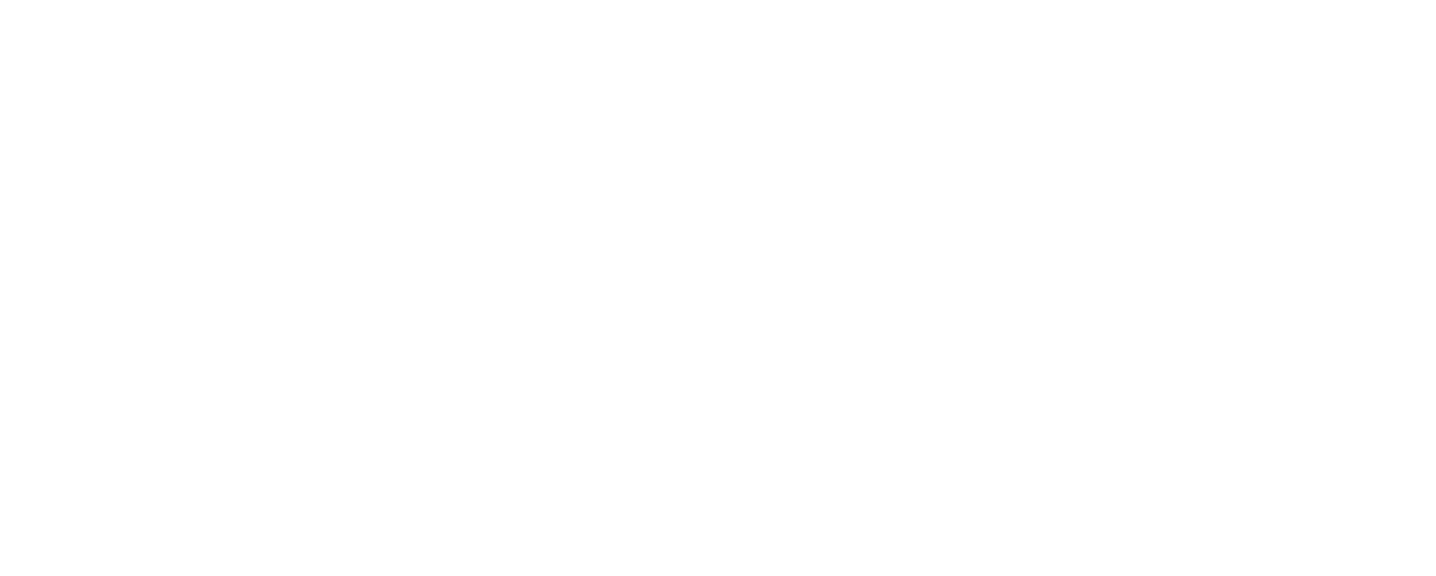

In [232]:
import graphviz

dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=locations,
    class_names=["Donald Trump", "Joe Biden"],
    filled=True,
    rounded=True,
    special_characters=True,
    impurity=False,   # remove gini
)

dot_data = dot_data.replace(
    "digraph Tree {",
    '''digraph Tree {\nsize="20,8!"\nratio="fill"\nrankdir=TB\ndpi=500
'''
)


graph = graphviz.Source(dot_data)
graph.render("./outputs/decision_tree", format="png", cleanup=True)
graph


In [233]:
param_grid = {
    'max_depth': [1, 3, 5, 7, 10, None],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20],        # Minimum samples required to split an internal node
    'criterion': ['gini', 'entropy']        # Function to measure the quality of a split
}
clf = DecisionTreeClassifier()
grid_search_rf = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='f1',
    cv=10,
    verbose=1,
    n_jobs=-1  # Use all cores for speed
)

# 4. Fit the Data (This starts the exhaustive search)
print("Starting Grid Search for Decision Tree...")
grid_search_rf.fit(X_train, Y_train)
print("Grid Search complete.")

y_pred = grid_search_rf.best_estimator_.predict(X_test)
print(classification_report(Y_test, y_pred))

Starting Grid Search for Decision Tree...
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Grid Search complete.
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       765
           1       0.90      0.92      0.91      1069

    accuracy                           0.89      1834
   macro avg       0.89      0.89      0.89      1834
weighted avg       0.89      0.89      0.89      1834



In [234]:
grid_search_rf.best_estimator_, clf

(DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20),
 DecisionTreeClassifier())

# Random Forest

In [235]:
from sklearn.ensemble import RandomForestClassifier

In [236]:
clf = RandomForestClassifier(max_depth=4)
clf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=4)

In [237]:
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       765
           1       0.92      0.93      0.93      1069

    accuracy                           0.92      1834
   macro avg       0.92      0.91      0.91      1834
weighted avg       0.92      0.92      0.92      1834



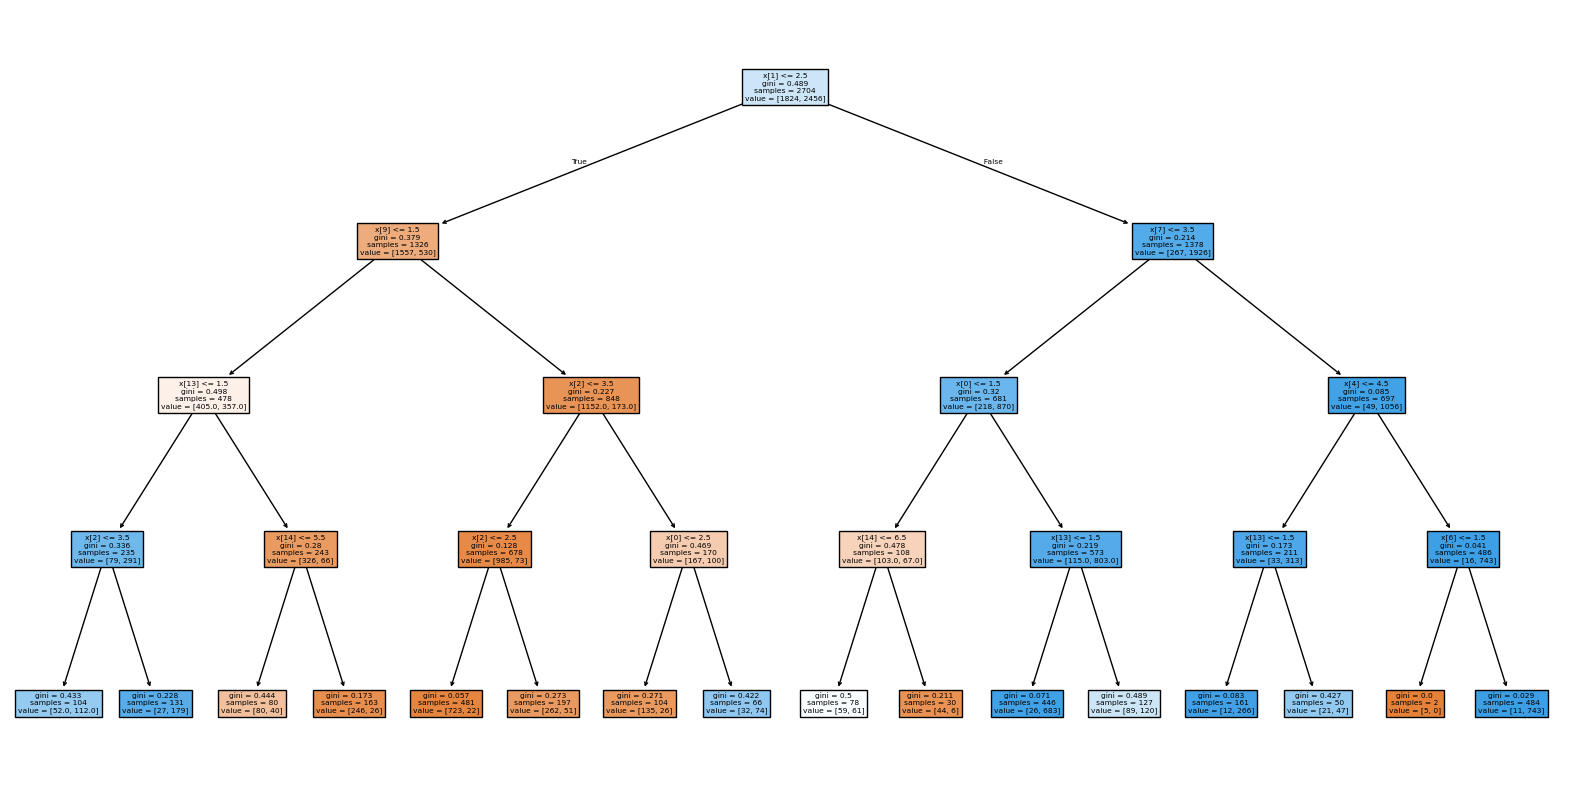

In [238]:
plt.figure(figsize=(20,10))
plot_tree(clf.estimators_[0], filled=True)
plt.show()

In [239]:
param_grid = {
    'n_estimators': [100, 200, 300],                # Number of trees in the forest
    'max_depth': [None, 1, 10, 20],                    # Maximum depth of the tree (None means unlimited)
    'min_samples_leaf': [1, 2, 4]                   # Minimum samples required to be at a leaf node
}
clf = RandomForestClassifier()
grid_search_rf = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1  # Use all cores for speed
)

# 4. Fit the Data (This starts the exhaustive search)
print("Starting Grid Search for Random Forest...")
grid_search_rf.fit(X_train, Y_train)
print("Grid Search complete.")

y_pred = grid_search_rf.best_estimator_.predict(X_test)
print(classification_report(Y_test, y_pred))

Starting Grid Search for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Grid Search complete.
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       765
           1       0.94      0.94      0.94      1069

    accuracy                           0.92      1834
   macro avg       0.92      0.92      0.92      1834
weighted avg       0.92      0.92      0.92      1834



# XGBoost

In [240]:
import xgboost as xgb

In [241]:
%%time
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=2)
xgb_model.fit(X_train, Y_train)

CPU times: user 350 ms, sys: 4.55 ms, total: 355 ms
Wall time: 33.2 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [242]:
y_pred = xgb_model.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       765
           1       0.93      0.93      0.93      1069

    accuracy                           0.92      1834
   macro avg       0.92      0.92      0.92      1834
weighted avg       0.92      0.92      0.92      1834



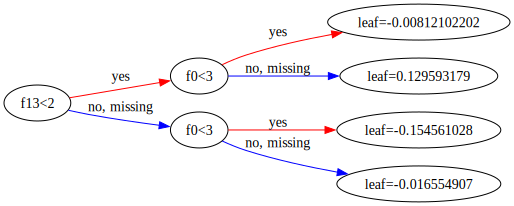

In [243]:
tree_graph = xgb.to_graphviz(xgb_model, tree_idx=3, rankdir='LR')
tree_graph

In [ ]:
clf = xgb.XGBClassifier(eval_metric='logloss')

param_grid = {
    'n_estimators': [100, 200, 300],          # Number of boosting rounds
    'max_depth': [3, 5, 7],                   # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],       # Step size shrinkage
    'subsample': [0.7, 0.8, 1.0],            # Fraction of samples for each tree
    'colsample_bytree': [0.7, 0.8, 1.0],     # Fraction of features for each tree
    'gamma': [0, 0.1, 0.2],                  # Minimum loss reduction required to make a split
    'reg_alpha': [0, 0.01, 0.1],             # L1 regularization term
    'reg_lambda': [1, 1.5, 2]                # L2 regularization term
}



# 3. Create the GridSearchCV Object
grid_search = GridSearchCV(
    estimator=clf,        # The model to tune
    param_grid=param_grid,     # The grid of hyperparameters
    scoring='f1',        # Metric for evaluation (e.g., 'accuracy', 'f1', 'roc_auc')
    cv=5,                      # Number of cross-validation folds
    verbose=2,                 # Controls the verbosity of the output (0=silent, 1=some messages, 2=full details)
    n_jobs=-1                  # Use all available CPU cores for parallel processing
)

# 4. Fit the Data (Run the exhaustive search)
print("Starting Grid Search...")
grid_search.fit(X_train, Y_train)
print("Grid Search complete.")

y_pred = grid_search.predict(X_test)
print(classification_report(Y_test, y_pred))

# KNN

In [244]:
from sklearn.neighbors import KNeighborsClassifier

In [245]:
%%time
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, Y_train)

CPU times: user 6.94 ms, sys: 0 ns, total: 6.94 ms
Wall time: 6.6 ms


KNeighborsClassifier()

In [246]:
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       765
           1       0.91      0.93      0.92      1069

    accuracy                           0.90      1834
   macro avg       0.90      0.90      0.90      1834
weighted avg       0.90      0.90      0.90      1834



In [251]:
clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],      # Number of neighbors to use
    'weights': ['uniform', 'distance'],   # How to weight neighbors
    'metric': ['euclidean', 'manhattan']  # Distance metric
}


# 3. Create the GridSearchCV Object
grid_search = GridSearchCV(
    estimator=clf,        # The model to tune
    param_grid=param_grid,     # The grid of hyperparameters
    scoring='f1',        # Metric for evaluation (e.g., 'accuracy', 'f1', 'roc_auc')
    cv=5,                      # Number of cross-validation folds
    verbose=2,                 # Controls the verbosity of the output (0=silent, 1=some messages, 2=full details)
    n_jobs=-1                  # Use all available CPU cores for parallel processing
)

# 4. Fit the Data (Run the exhaustive search)
print("Starting Grid Search...")
grid_search.fit(X_train, Y_train)
print("Grid Search complete.")

y_pred = grid_search.predict(X_test)
print(classification_report(Y_test, y_pred))

Starting Grid Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Grid Search complete.
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       765
           1       0.92      0.94      0.93      1069

    accuracy                           0.92      1834
   macro avg       0.92      0.91      0.91      1834
weighted avg       0.92      0.92      0.92      1834



# Naive Bayes

In [30]:
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB

In [31]:
gnb = GaussianNB()

In [32]:
%%time
gnb.fit(X_train, Y_train)

CPU times: user 1.83 ms, sys: 979 μs, total: 2.8 ms
Wall time: 1.98 ms


GaussianNB()

In [33]:
y_pred = gnb.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       765
           1       0.94      0.93      0.94      1069

    accuracy                           0.93      1834
   macro avg       0.92      0.93      0.92      1834
weighted avg       0.93      0.93      0.93      1834



In [250]:
clf = GaussianNB()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Laplace-like smoothing
}



# 3. Create the GridSearchCV Object
grid_search = GridSearchCV(
    estimator=clf,        # The model to tune
    param_grid=param_grid,     # The grid of hyperparameters
    scoring='f1',        # Metric for evaluation (e.g., 'accuracy', 'f1', 'roc_auc')
    cv=5,                      # Number of cross-validation folds
    verbose=2,                 # Controls the verbosity of the output (0=silent, 1=some messages, 2=full details)
    n_jobs=-1                  # Use all available CPU cores for parallel processing
)

# 4. Fit the Data (Run the exhaustive search)
print("Starting Grid Search...")
grid_search.fit(X_train, Y_train)
print("Grid Search complete.")

y_pred = grid_search.predict(X_test)
print(classification_report(Y_test, y_pred))

Starting Grid Search...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Grid Search complete.
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       765
           1       0.94      0.93      0.94      1069

    accuracy                           0.93      1834
   macro avg       0.92      0.93      0.92      1834
weighted avg       0.93      0.93      0.93      1834



# NN

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

ModuleNotFoundError: No module named 'torch'

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=64, shuffle=True)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model, loss, and optimizer
model = SimpleNN(input_dim=X_train.shape[1], hidden_dim=64, output_dim=len(set(Y_train))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in tqdm(range(50)):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


# Predict on test set
with torch.no_grad():
    model = model.to("cpu")
    preds = model(X_test_t).argmax(dim=1)

# Evaluate accuracy
acc = accuracy_score(Y_test, preds.numpy())
print(f"Test Accuracy: {acc:.4f}")

print(classification_report(Y_test, preds))

In [ ]:
class ImprovedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),          # Regularization
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # Xavier initialization
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# ==== Initialize model, optimizer, loss ====
model = ImprovedNN(input_dim=X_train.shape[1], hidden_dim=128, output_dim=len(set(Y_train))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Training loop
for epoch in tqdm(range(500)):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()



# Predict on test set
with torch.no_grad():
    model = model.to("cpu")
    preds = model(X_test_t).argmax(dim=1)

# Evaluate accuracy
acc = accuracy_score(Y_test, preds.numpy())
print(f"Test Accuracy: {acc:.4f}")

print(classification_report(Y_test, preds))

In [ ]:
class TransformerNN(nn.Module):
    def __init__(self, input_dim, num_classes, dim_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, dim_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_model, nhead=nhead, dim_feedforward=256, dropout=0.3)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim_model),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(dim_model, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # Treat features as sequence length = 1
        x = self.input_projection(x).unsqueeze(1)  # [batch, seq_len=1, dim]
        x = self.transformer(x)                    # [batch, seq_len=1, dim]
        x = x.mean(dim=1)                          # pool
        return self.classifier(x)

model = TransformerNN(input_dim=X_train.shape[1], num_classes=len(set(Y_train))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Training loop
for epoch in tqdm(range(500)):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()



# Predict on test set
with torch.no_grad():
    model = model.to("cpu")
    preds = model(X_test_t).argmax(dim=1)

# Evaluate accuracy
acc = accuracy_score(Y_test, preds.numpy())
print(f"Test Accuracy: {acc:.4f}")

print(classification_report(Y_test, preds))